In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import statsmodels as sm
from scipy import stats as ss
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))
pd.set_option('display.width', 999999)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 999
from pylabs.projects.bbc.pairing import dwipairing

IOError: [Errno 2] No such file or directory: 'style-table.css'

In [3]:
!pwd

/Users/mrjeffs


In [9]:
#get data from test file
testvtkf = fs / 'bbc' / 'allvtk_channel_run7.csv'
#testvtkf = fs / 'bbc' / 'testvtk_run5.csv'
testvtk_fbs = pd.read_csv(testvtkf)
#this renames col label 'subjectid' with 'vtk_file_name'
testvtk_fbs.rename(columns={'subjectid': 'vtk_file_name', 'icountgood': 'FB_reach_dest', 'icounttotal': 'total_num_FB'}, inplace=True)
#makes subj id fm 1st 10 chars of vtk_file_name
testvtk_fbs['Subjid'] = testvtk_fbs['vtk_file_name'].str[0:10]
#makes fit methods
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('restore_cam_tensor_medfilt'), 'fit_method'] = 'restore_camino_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('restore_cam_tensor_mori'), 'fit_method'] = 'restore_camino'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_cam_tensor_medfilt'), 'fit_method'] = 'wls_camino_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_cam_tensor_mori'), 'fit_method'] = 'wls_camino'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_cam_tensor_medfilt'), 'fit_method'] = 'ols_camino_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_cam_tensor_mori'), 'fit_method'] = 'ols_camino'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('restore_dipy_tensor_mori'), 'fit_method'] = 'restore_dipy'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('restore_dipy_tensor_med'), 'fit_method'] = 'restore_dipy_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_dipy_tensor_mori'), 'fit_method'] = 'ols_dipy'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_dipy_tensor_med'), 'fit_method'] = 'ols_dipy_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_dipy_tensor_mori'), 'fit_method'] = 'wls_dipy'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_dipy_tensor_medfilt'), 'fit_method'] = 'wls_dipy_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_fsl_tensor_medfilt'), 'fit_method'] = 'ols_fsl_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('ols_fsl_tensor_mori'), 'fit_method'] = 'ols_fsl'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_fsl_tensor_medfilt'), 'fit_method'] = 'wls_fsl_mf'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('wls_fsl_tensor_mori'), 'fit_method'] = 'wls_fsl'
#makes region names for regions col.
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('LeftPostIntCap'), 'region'] = 'LeftPostIntCap'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('RightPostIntCap'), 'region'] = 'RightPostIntCap'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('Left_IFOF-45'), 'region'] = 'Left_IFOF'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('Right_IFOF-133'), 'region'] = 'Right_IFOF'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('mori_CC'), 'region'] = 'Corpus_Callosum'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('Left_SLF-43'), 'region'] = 'Left_SLF'
testvtk_fbs.loc[testvtk_fbs['vtk_file_name'].str.contains('Right_SLF-131'), 'region'] = 'Right_SLF'
#calculate %FB arrive at target as float and formatted text for display
testvtk_fbs['arrived'] = 1 - testvtk_fbs['total_num_FB'].sub(testvtk_fbs['FB_reach_dest']).div(testvtk_fbs['total_num_FB'])
testvtk_fbs['perc_arr'] = pd.Series(["{0:.2f}%".format(val*100) for val in testvtk_fbs['arrived']], index = testvtk_fbs.index)

In [21]:
start = testvtk_fbs.set_index(['Subjid', 'fit_method', 'region'])#, 'fa', 'ad', 'rd', 'md', 'length', 'arrived', 'FB_reach_dest', 'total_num_FB'])
start = start.drop('vtk_file_name', axis=1)

In [24]:
start.head()#unstack(0)

fa            ad            rd            md     length  FB_reach_dest  total_num_FB   arrived perc_arr
Subjid     fit_method        region                                                                                                                        
sub-bbc101 restore_camino_mf Corpus_Callosum  0.380762  8.562840e-10  7.527851e-10  7.872827e-10  220.95491           2373          2694  0.880846   88.08%
                             Left_IFOF        0.380762  8.562840e-10  7.527851e-10  7.872827e-10  220.95491           2373          2694  0.880846   88.08%
                             LeftPostIntCap   0.380762  8.562840e-10  7.527851e-10  7.872827e-10  220.95491           2373          2694  0.880846   88.08%
                             Left_SLF         0.380762  8.562840e-10  7.527851e-10  7.872827e-10  220.95491           2373          2694  0.880846   88.08%
                             Right_IFOF       0.380762  8.562840e-10  7.527851e-10  7.872827e-10  220.95491           2373          2694  0.880846   88.08%

In [17]:
start.groupby(['fit_method', 'region']).fa.mean()

KeyError: 'fit_method'

In [6]:
startuS = start.unstack(0)
startuFM = startuS.unstack(0)
startuR = startuFM.unstack(0)
startuRsFA = startuR.stack(0).isna
startuRsFA

Subjid                      sub-bbc106                                                                                                                                       ...          sub-bbc208                                                                                                                           
fit_method               ols_camino_mf                                                                                                wls_fsl                                ...       ols_camino_mf                                     wls_fsl                                                                               
region                 Corpus_Callosum LeftPostIntCap     Left_IFOF      Left_SLF RightPostIntCap    Right_IFOF     Right_SLF Corpus_Callosum LeftPostIntCap   Left_IFOF     ...     RightPostIntCap    Right_IFOF     Right_SLF Corpus_Callosum LeftPostIntCap   Left_IFOF    Left_SLF RightPostIntCap  Right_IFOF   Right_SLF
teststat                                                                                                                                                                     ...                                                                                                                                               
1        fa               3.926232e-01            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         ad               8.520000e-10            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         rd               7.350000e-10            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         md               7.740000e-10            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         length           2.008241e+02            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         arrived          7.720917e-01            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         FB_reach_dest    2.761000e+03            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
         total_num_FB     3.576000e+03            NaN           NaN           NaN             NaN           NaN           NaN             NaN            NaN         NaN     ...                 NaN           NaN           NaN             NaN            NaN         NaN         NaN             NaN         NaN         NaN
2        fa                        NaN            NaN  2.982346e-01           NaN             NaN           NaN           NaN             NaN            NaN    

In [7]:
startuRsFA['sub-bbc202'] - startuRsFA['sub-bbc106']

fit_method               ols_camino_mf                                                                                wls_fsl                                                                       
region                 Corpus_Callosum LeftPostIntCap Left_IFOF Left_SLF RightPostIntCap Right_IFOF Right_SLF Corpus_Callosum LeftPostIntCap Left_IFOF Left_SLF RightPostIntCap Right_IFOF Right_SLF
teststat                                                                                                                                                                                            
1        fa                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         ad                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         rd                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         md                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         length                    NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         arrived                   NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         FB_reach_dest             NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         total_num_FB              NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
2        fa                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         ad                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         rd                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         md                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         length                    NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         arrived                   NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         FB_reach_dest             NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         total_num_FB              NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
3        fa                        NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
         ad                        NaN            NaN       

In [9]:
startu3 = startu2.unstack(0)
startu3

fa                                                                                                                     ...       total_num_FB                                                                                                            
Subjid          sub-bbc106                                                                                                                     ...         sub-bbc208                                                                                                            
fit_method   ols_camino_mf                                                                                 wls_fsl                             ...      ols_camino_mf                              wls_fsl                                                                       
region     Corpus_Callosum LeftPostIntCap Left_IFOF  Left_SLF RightPostIntCap Right_IFOF Right_SLF Corpus_Callosum LeftPostIntCap Left_IFOF    ...    RightPostIntCap Right_IFOF Right_SLF Corpus_Callosum LeftPostIntCap Left_IFOF Left_SLF RightPostIntCap Right_IFOF Right_SLF
teststat                                                                                                                                       ...                                                                                                                               
1                 0.392623            NaN       NaN       NaN             NaN        NaN       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
2                      NaN            NaN  0.298235       NaN             NaN        NaN       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
3                      NaN       0.396717       NaN       NaN             NaN        NaN       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
4                      NaN            NaN       NaN  0.351318             NaN        NaN       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
5                      NaN            NaN       NaN       NaN             NaN   0.326398       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
6                      NaN            NaN       NaN       NaN        0.381936        NaN       NaN             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
7                      NaN            NaN       NaN       NaN             NaN        NaN  0.301638             NaN            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
8                      NaN            NaN       NaN       NaN             NaN        NaN       NaN        0.460283            NaN       NaN    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
9                      NaN            NaN       NaN       NaN             NaN        NaN       NaN             NaN            NaN  0.403015    ...                NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
10                     NaN            NaN       NaN       NaN             NaN        NaN       NaN             NaN       0.483272       NaN    ...                NaN        NaN       NaN  

In [12]:
startu3.fa['sub-bbc202'] - startu3.fa['sub-bbc106']

fit_method   ols_camino_mf                                                                                wls_fsl                                                                       
region     Corpus_Callosum LeftPostIntCap Left_IFOF Left_SLF RightPostIntCap Right_IFOF Right_SLF Corpus_Callosum LeftPostIntCap Left_IFOF Left_SLF RightPostIntCap Right_IFOF Right_SLF
teststat                                                                                                                                                                                
1                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
2                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
3                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
4                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
5                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
6                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
7                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
8                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
9                      NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
10                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
11                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
12                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
13                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
14                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
15                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
16                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
17                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
18                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN            NaN       NaN      NaN             NaN        NaN       NaN
19                     NaN            NaN       NaN      NaN             NaN        NaN       NaN             NaN  

In [17]:
testvtk_fbs.groupby(['Subjid', 'fit_method', 'region']).fa.mean()

Subjid      fit_method     region         
sub-bbc106  ols_camino_mf  Corpus_Callosum    0.392623
                           LeftPostIntCap     0.396717
                           Left_IFOF          0.298235
                           Left_SLF           0.351318
                           RightPostIntCap    0.381936
                           Right_IFOF         0.326398
                           Right_SLF          0.301638
            wls_fsl        Corpus_Callosum    0.460283
                           LeftPostIntCap     0.483272
                           Left_IFOF          0.403015
                           Left_SLF           0.417562
                           RightPostIntCap    0.472359
                           Right_IFOF         0.394820
                           Right_SLF          0.372700
sub-bbc108  ols_camino_mf  Corpus_Callosum    0.386328
                           LeftPostIntCap     0.400841
                           Left_IFOF          0.334101
                      

In [ ]:
#setup pairing test 2 only
test_foster_sids = {0:'sub-bbc106', 1:'sub-bbc108'}
test_control_sids = {0:'sub-bbc202', 1:'sub-bbc208'}
test_pairs = {i:(c, f) for i, (c,f) in enumerate(zip(test_control_sids.values(),test_foster_sids.values()))}

In [2]:
vtkf = fs / 'bbc' / 'allvtk_run5.csv'
vtk_fbs = pd.read_csv(vtkf)

In [3]:
#this renames col label 'subjectid' with 'vtk_file_name'
vtk_fbs.rename(columns={'subjectid': 'vtk_file_name', 'icountgood': 'FB_reach_dest', 'icounttotal': 'total_num_FB'}, inplace=True)
#makes subj id fm 1st 10 chars of vtk_file_name
vtk_fbs['Subjid'] = vtk_fbs['vtk_file_name'].str[0:10]
#makes fit methods
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('restore_cam_tensor_medfilt'), 'fit_method'] = 'restore_camino_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('restore_cam_tensor_mori'), 'fit_method'] = 'restore_camino'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_cam_tensor_medfilt'), 'fit_method'] = 'wls_camino_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_cam_tensor_mori'), 'fit_method'] = 'wls_camino'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_cam_tensor_medfilt'), 'fit_method'] = 'ols_camino_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_cam_tensor_mori'), 'fit_method'] = 'ols_camino'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('restore_dipy_tensor_mori'), 'fit_method'] = 'restore_dipy'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('restore_dipy_tensor_med'), 'fit_method'] = 'restore_dipy_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_dipy_tensor_mori'), 'fit_method'] = 'ols_dipy'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_dipy_tensor_med'), 'fit_method'] = 'ols_dipy_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_dipy_tensor_mori'), 'fit_method'] = 'wls_dipy'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_dipy_tensor_medfilt'), 'fit_method'] = 'wls_dipy_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_fsl_tensor_medfilt'), 'fit_method'] = 'ols_fsl_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('ols_fsl_tensor_mori'), 'fit_method'] = 'ols_fsl'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_fsl_tensor_medfilt'), 'fit_method'] = 'wls_fsl_mf'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('wls_fsl_tensor_mori'), 'fit_method'] = 'wls_fsl'
#makes region names for regions col.
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('LeftPostIntCap'), 'region'] = 'LeftPostIntCap'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('RightPostIntCap'), 'region'] = 'RightPostIntCap'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('Left_IFOF-45'), 'region'] = 'Left_IFOF'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('Right_IFOF-133'), 'region'] = 'Right_IFOF'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('mori_CC'), 'region'] = 'Corpus_Callosum'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('Left_SLF-43'), 'region'] = 'Left_SLF'
vtk_fbs.loc[vtk_fbs['vtk_file_name'].str.contains('Right_SLF-131'), 'region'] = 'Right_SLF'
#calculate %FB arrive at target as float and formatted text for display
vtk_fbs['arrived'] = 1 - vtk_fbs['total_num_FB'].sub(vtk_fbs['FB_reach_dest']).div(vtk_fbs['total_num_FB'])
vtk_fbs['perc_arr'] = pd.Series(["{0:.2f}%".format(val*100) for val in vtk_fbs['arrived']], index = vtk_fbs.index)

In [5]:
vtk_fbs.ix[0:10]

,vtk_file_name,fa,ad,rd,md,vo,length,FB_reach_dest,total_num_FB,Subjid,fit_method,region,arrived,perc_arr
0,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_CC.vtk,0.380762,8.562840e-10,7.527851e-10,7.872827e-10,1,220.954910,2373,2694,sub-bbc101,restore_camino_mf,Corpus_Callosum,0.880846,88.08%
1,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Left_IFOF-45-47.vtk,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,0,82,sub-bbc101,restore_camino_mf,Left_IFOF,0.000000,0.00%
2,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_LeftPostIntCap-35.vtk,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,0,308,sub-bbc101,restore_camino_mf,LeftPostIntCap,0.000000,0.00%
3,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Left_SLF-43.vtk,0.245757,7.620332e-10,6.627387e-10,6.958369e-10,1,164.010010,2,312,sub-bbc101,restore_camino_mf,Left_SLF,0.006410,0.64%
4,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Right_IFOF-133-135.vtk,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,0,54,sub-bbc101,restore_camino_mf,Right_IFOF,0.000000,0.00%
5,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_RightPostIntCap-123.vtk,0.287925,6.078071e-10,7.872144e-10,7.274122e-10,1,196.659332,20,245,sub-bbc101,restore_camino_mf,RightPostIntCap,0.081633,8.16%
6,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Right_SLF-131.vtk,0.242309,7.783412e-10,6.888110e-10,7.186543e-10,1,158.584732,11,125,sub-bbc101,restore_camino_mf,Right_SLF,0.088000,8.80%
7,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_CC.vtk,0.417196,8.699177e-10,7.634652e-10,7.989497e-10,1,199.373734,2046,2707,sub-bbc101,restore_camino,Corpus_Callosum,0.755818,75.58%
8,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_Left_IFOF-45-47.vtk,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,0,172,sub-bbc101,restore_camino,Left_IFOF,0.000000,0.00%
9,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_LeftPostIntCap-35.vtk,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000,0,315,sub-bbc101,restore_camino,LeftPostIntCap,0.000000,0.00%


In [19]:
#shows flat file no multiIndex
testrange = np.arange(0, len(vtk_fbs), int(len(vtk_fbs)/19))
vtk_fbs.ix[testrange,['Subjid', 'fit_method', 'region', 'vtk_file_name', 'fa', 'md', 'FB_reach_dest', 'total_num_FB', 'perc_arr']]

,Subjid,fit_method,region,vtk_file_name,fa,md,FB_reach_dest,total_num_FB,perc_arr
0,sub-bbc101,restore_camino_mf,Corpus_Callosum,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_CC.vtk,0.380762,7.872827e-10,2373,2694,88.08%
144,sub-bbc105,wls_dipy_mf,NaN,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_Right_IFOF-133-135.vtk,0.400263,8.776074e-04,10,376,2.66%
288,sub-bbc108,ols_camino,NaN,sub-bbc108_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_cam_tensor_mori_Left_IFOF-45-47.vtk,0.412255,7.783389e-10,61,376,16.22%
432,sub-bbc108,ols_fsl,RightPostIntCap,sub-bbc108_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_fsl_tensor_mori_RightPostIntCap-123.vtk,0.470642,7.593266e-04,135,356,37.92%
576,sub-bbc113,wls_camino_mf,LeftPostIntCap,sub-bbc113_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_cam_tensor_medfilt_mori_LeftPostIntCap-35.vtk,0.387892,7.538993e-10,131,351,37.32%
720,sub-bbc116,wls_fsl_mf,Right_SLF,sub-bbc116_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_medfilt_mori_Right_SLF-131.vtk,0.278265,6.782556e-04,53,151,35.10%
864,sub-bbc119,ols_dipy,Left_SLF,sub-bbc119_ses-2_dti_15dir_b1000_2_eddy_corrected_repol_std2_ols_dipy_tensor_mori_Left_SLF-43.vtk,0.402397,7.802900e-04,92,314,29.30%
1008,sub-bbc120,restore_dipy_mf,Corpus_Callosum,sub-bbc120_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_dipy_tensor_medfilt_mori_CC.vtk,0.517007,8.741005e-04,2222,3304,67.25%
1152,sub-bbc202,wls_dipy_mf,NaN,sub-bbc202_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_Right_IFOF-133-135.vtk,0.397473,7.628877e-04,30,297,10.10%
1296,sub-bbc209,ols_camino,NaN,sub-bbc209_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_cam_tensor_mori_Left_IFOF-45-47.vtk,0.391794,8.029737e-10,31,413,7.51%


In [6]:
#make into multiIndex
sid = np.array(vtk_fbs.ix[:,['Subjid']]).ravel()
fitm = np.array(vtk_fbs.ix[:,['fit_method']]).ravel()
reg = np.array(vtk_fbs.ix[:,['region']]).ravel()
mi_array = np.array([sid, fitm, reg])
index = pd.MultiIndex.from_arrays(mi_array, names=['Subjid', 'fit_method', 'region'])
vtk_fbmi = pd.DataFrame(vtk_fbs.values, index=index, columns=vtk_fbs.columns)

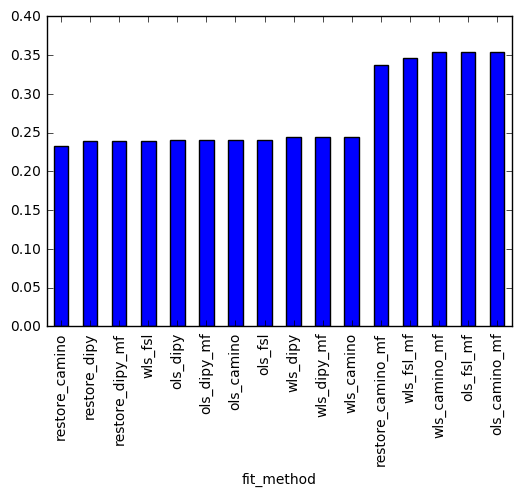

In [21]:
vtk_fbs.groupby('fit_method').arrived.mean().sort_values().plot(kind='Bar') #, vtk_fbs.groupby('fit_method').FB_reach_dest.sum().rank().sort_values()

In [8]:
vtkfr5 = fs / 'bbc' / 'allvtk_run5.csv'
vtk_fbs_r5 = pd.read_csv(vtkfr5)
#this renames col label 'subjectid' with 'vtk_file_name'
vtk_fbs_r5.rename(columns={'subjectid': 'vtk_file_name', 'icountgood': 'FB_reach_dest', 'icounttotal': 'total_num_FB'}, inplace=True)
#makes subj id fm 1st 10 chars of vtk_file_name
vtk_fbs_r5['Subjid'] = vtk_fbs_r5['vtk_file_name'].str[0:10]

In [9]:
#makes fit methods
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('restore_cam_tensor_medfilt'), 'fit_method'] = 'restore_camino_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('restore_cam_tensor_mori'), 'fit_method'] = 'restore_camino'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_cam_tensor_medfilt'), 'fit_method'] = 'wls_camino_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_cam_tensor_mori'), 'fit_method'] = 'wls_camino'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_cam_tensor_medfilt'), 'fit_method'] = 'ols_camino_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_cam_tensor_mori'), 'fit_method'] = 'ols_camino'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('restore_dipy_tensor_mori'), 'fit_method'] = 'restore_dipy'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('restore_dipy_tensor_med'), 'fit_method'] = 'restore_dipy_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_dipy_tensor_mori'), 'fit_method'] = 'ols_dipy'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_dipy_tensor_med'), 'fit_method'] = 'ols_dipy_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_dipy_tensor_mori'), 'fit_method'] = 'wls_dipy'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_dipy_tensor_medfilt'), 'fit_method'] = 'wls_dipy_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_fsl_tensor_medfilt'), 'fit_method'] = 'ols_fsl_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('ols_fsl_tensor_mori'), 'fit_method'] = 'ols_fsl'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_fsl_tensor_medfilt'), 'fit_method'] = 'wls_fsl_mf'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('wls_fsl_tensor_mori'), 'fit_method'] = 'wls_fsl'
#makes region names for regions col.
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('LeftPostIntCap'), 'region'] = 'LeftPostIntCap'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('RightPostIntCap'), 'region'] = 'RightPostIntCap'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('Left_IFOF-45'), 'region'] = 'Left_IFOF'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('Right_IFOF-133'), 'region'] = 'Right_IFOF'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('mori_CC'), 'region'] = 'Corpus_Callosum'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('Left_SLF-43'), 'region'] = 'Left_SLF'
vtk_fbs_r5.loc[vtk_fbs_r5['vtk_file_name'].str.contains('Right_SLF-131'), 'region'] = 'Right_SLF'
#calculate %FB arrive at target as float and formatted text for display
vtk_fbs_r5['arrived'] = 1 - vtk_fbs_r5['total_num_FB'].sub(vtk_fbs_r5['FB_reach_dest']).div(vtk_fbs_r5['total_num_FB'])
vtk_fbs_r5['perc_arr'] = pd.Series(["{0:.2f}%".format(val*100) for val in vtk_fbs_r5['arrived']], index = vtk_fbs_r5.index)

In [10]:
#shows flat file no multiIndex
testrange = np.arange(0, len(vtk_fbs_r5), int(len(vtk_fbs_r5)/19))
vtk_fbs_r5.ix[testrange,['Subjid', 'fit_method', 'region', 'vtk_file_name', 'fa', 'md', 'FB_reach_dest', 'total_num_FB', 'perc_arr']]

,Subjid,fit_method,region,vtk_file_name,fa,md,FB_reach_dest,total_num_FB,perc_arr
0,sub-bbc101,restore_camino_mf,Corpus_Callosum,sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_CC.vtk,0.380762,7.872827e-10,2373,2694,88.08%
144,sub-bbc105,wls_dipy_mf,Right_IFOF,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_Right_IFOF-133-135.vtk,0.400263,8.776074e-04,10,376,2.66%
288,sub-bbc108,ols_camino,Left_IFOF,sub-bbc108_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_cam_tensor_mori_Left_IFOF-45-47.vtk,0.412255,7.783389e-10,61,376,16.22%
432,sub-bbc108,ols_fsl,RightPostIntCap,sub-bbc108_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_fsl_tensor_mori_RightPostIntCap-123.vtk,0.470642,7.593266e-04,135,356,37.92%
576,sub-bbc113,wls_camino_mf,LeftPostIntCap,sub-bbc113_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_cam_tensor_medfilt_mori_LeftPostIntCap-35.vtk,0.387892,7.538993e-10,131,351,37.32%
720,sub-bbc116,wls_fsl_mf,Right_SLF,sub-bbc116_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_medfilt_mori_Right_SLF-131.vtk,0.278265,6.782556e-04,53,151,35.10%
864,sub-bbc119,ols_dipy,Left_SLF,sub-bbc119_ses-2_dti_15dir_b1000_2_eddy_corrected_repol_std2_ols_dipy_tensor_mori_Left_SLF-43.vtk,0.402397,7.802900e-04,92,314,29.30%
1008,sub-bbc120,restore_dipy_mf,Corpus_Callosum,sub-bbc120_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_dipy_tensor_medfilt_mori_CC.vtk,0.517007,8.741005e-04,2222,3304,67.25%
1152,sub-bbc202,wls_dipy_mf,Right_IFOF,sub-bbc202_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_Right_IFOF-133-135.vtk,0.397473,7.628877e-04,30,297,10.10%
1296,sub-bbc209,ols_camino,Left_IFOF,sub-bbc209_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_cam_tensor_mori_Left_IFOF-45-47.vtk,0.391794,8.029737e-10,31,413,7.51%


In [11]:
#make into multiIndex
sid_r5 = np.array(vtk_fbs_r5.ix[:,['Subjid']]).ravel()
fitm_r5 = np.array(vtk_fbs_r5.ix[:,['fit_method']]).ravel()
reg_r5 = np.array(vtk_fbs_r5.ix[:,['region']]).ravel()
mi_array_r5 = np.array([sid_r5, fitm_r5, reg_r5])
index_r5 = pd.MultiIndex.from_arrays(mi_array_r5, names=['Subjid', 'fit_method', 'region'])
vtk_fbmi_r5 = pd.DataFrame(vtk_fbs_r5.values, index=index_r5, columns=vtk_fbs_r5.columns)

In [12]:
vtk_fbmi_r5.ix[0:224]

vtk_file_name        fa           ad           rd           md vo   length FB_reach_dest total_num_FB      Subjid         fit_method           region     arrived perc_arr
Subjid     fit_method        region                                                                                                                                                                                                                                                                                             
sub-bbc101 restore_camino_mf Corpus_Callosum                    sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_CC.vtk  0.380762  8.56284e-10  7.52785e-10  7.87283e-10  1  220.955          2373         2694  sub-bbc101  restore_camino_mf  Corpus_Callosum    0.880846   88.08%
                             Left_IFOF             sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Left_IFOF-45-47.vtk         0            0            0            0  0        0             0           82  sub-bbc101  restore_camino_mf        Left_IFOF           0    0.00%
                             LeftPostIntCap      sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_LeftPostIntCap-35.vtk         0            0            0            0  0        0             0          308  sub-bbc101  restore_camino_mf   LeftPostIntCap           0    0.00%
                             Left_SLF                  sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Left_SLF-43.vtk  0.245757  7.62033e-10  6.62739e-10  6.95837e-10  1   164.01             2          312  sub-bbc101  restore_camino_mf         Left_SLF  0.00641026    0.64%
                             Right_IFOF         sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Right_IFOF-133-135.vtk         0            0            0            0  0        0             0           54  sub-bbc101  restore_camino_mf       Right_IFOF           0    0.00%
                             RightPostIntCap   sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_RightPostIntCap-123.vtk  0.287925  6.07807e-10  7.87214e-10  7.27412e-10  1  196.659            20          245  sub-bbc101  restore_camino_mf  RightPostIntCap   0.0816327    8.16%
                             Right_SLF               sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_medfilt_mori_Right_SLF-131.vtk  0.242309  7.78341e-10  6.88811e-10  7.18654e-10  1  158.585            11          125  sub-bbc101  restore_camino_mf        Right_SLF       0.088    8.80%
           restore_camino    Corpus_Callosum                            sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_CC.vtk  0.417196  8.69918e-10  7.63465e-10   7.9895e-10  1  199.374          2046         2707  sub-bbc101     restore_camino  Corpus_Callosum    0.755818   75.58%
                             Left_IFOF                     sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_Left_IFOF-45-47.vtk         0            0            0            0  0        0             0          172  sub-bbc101     restore_camino        Left_IFOF           0    0.00%
                             LeftPostIntCap              sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_LeftPostIntCap-35.vtk         0            0            0            0  0        0             0          315  sub-bbc101     restore_camino   LeftPostIntCap           0    0.00%
                             Left_SLF                          sub-bbc101_ses-2_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam_tensor_mori_Left_SLF-43.vtk  0.303834  7.42363e-10  7.08826e-10  7.20005e-10  1  114.665            33          387  sub-bbc101     restore_camino         Left_SL

In [14]:
vtk_fbmi_r5.groupby('fit_method').arrived.mean().rank().sort_values()#, vtk_fbmi_r5.groupby('fit_method').FB_reach_dest.sum().rank().sort_values()

DataError: No numeric types to aggregate

KeyError: 'fit_method'

,Subjid,fit_method,region,vtk_file_name,FB_reach_dest,total_num_FB,FB_percent_reach_dest
31,sub-bbc105,NaN,RightPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_restore_cam2fsl_tensor_mori_RightPostIntCap-123.vtk,225,384,41.41%
32,sub-bbc105,wls_dipy_mf,LeftPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_LeftPostIntCap-35.vtk,203,418,51.44%
33,sub-bbc105,wls_dipy_mf,RightPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_medfilt_mori_RightPostIntCap-123.vtk,355,397,10.58%
34,sub-bbc105,wls_dipy,LeftPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_mori_LeftPostIntCap-35.vtk,126,408,69.12%
35,sub-bbc105,wls_dipy,RightPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_dipy_tensor_mori_RightPostIntCap-123.vtk,239,385,37.92%
36,sub-bbc105,wls_fsl_mf,LeftPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_medfilt_mori_LeftPostIntCap-35.vtk,203,415,51.08%
37,sub-bbc105,wls_fsl_mf,RightPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_medfilt_mori_RightPostIntCap-123.vtk,349,395,11.65%
38,sub-bbc105,wls_fsl,LeftPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_mori_LeftPostIntCap-35.vtk,118,406,70.94%
39,sub-bbc105,wls_fsl,RightPostIntCap,sub-bbc105_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_wls_fsl_tensor_mori_RightPostIntCap-123.vtk,232,378,38.62%
40,sub-bbc106,ols_dipy_mf,LeftPostIntCap,sub-bbc106_ses-1_dti_15dir_b1000_1_eddy_corrected_repol_std2_ols_dipy_tensor_medfilt_mori_LeftPostIntCap-35.vtk,248,458,45.85%


In [18]:
sid_lst = vtk_fbs.Subjid.unique()
fitm_lst = vtk_fbs.fit_method.unique()
region_lst = vtk_fbs.region.unique()
idx_arr = [sid_lst, fitm_lst, region_lst]
tuples = list(zip(sid_lst, fitm_lst, region_lst))

vtk_fbs.set_index(['Subjid', 'fit_method', 'region'], inplace=True)

In [21]:
vtk_fbs['FB_percent_reach_dest']

Subjid      fit_method         region         
sub-bbc101  ols_dipy_mf        LeftPostIntCap     100.00%
                               RightPostIntCap     80.88%
            ols_dipy           LeftPostIntCap     100.00%
                               RightPostIntCap     85.82%
            ols_fsl_mf         LeftPostIntCap      98.96%
                               RightPostIntCap     92.44%
            ols_fsl            LeftPostIntCap      99.34%
                               RightPostIntCap     94.07%
            NaN                LeftPostIntCap     100.00%
                               RightPostIntCap     91.84%
                               LeftPostIntCap     100.00%
                               RightPostIntCap     96.80%
            wls_dipy_mf        LeftPostIntCap      99.11%
                               RightPostIntCap     89.11%
            wls_dipy           LeftPostIntCap      99.40%
                               RightPostIntCap     87.64%
            wls_fsl_mf   

In [3]:
testf = fs / 'bbc' / 'vtk_df_test.csv'

In [5]:
testVTK_DF = pd.read_csv(testf, header=0, index_col=['Subjid', 'fit_method', 'region'])

ValueError: Index Subjid invalid

In [5]:
#this renames col label 'subjectid' with 'vtk_file_name'
testVTK_DF.rename(columns={'subjectid': 'vtk_file_name', 'icountgood': 'FB_reach_dest', 'icounttotal': 'total_num_FB'}, inplace=True)
#makes subj id fm 1st 10 chars of vtk_file_name
testVTK_DF['Subjid'] = testVTK_DF['vtk_file_name'].str[0:10]
#makes fit methods
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('restore_cam2fsl_tensor_medf'), 'fit_method'] = 'restore_camino'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('wls_fsl_tensor_medf'), 'fit_method'] = 'wls_fsl_mf'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('ols_dipy_tensor_med'), 'fit_method'] = 'ols_dipy_mf'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('wls_cam_tensor_medf'), 'fit_method'] = 'wls_camino_mf'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('wls_cam_tensor_mori'), 'fit_method'] = 'wls_camino'
#makes region names for regions col.
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('LeftPostIntCap'), 'region'] = 'LeftPostIntCap'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('RightPostIntCap'), 'region'] = 'RightPostIntCap'
testVTK_DF.loc[testVTK_DF['vtk_file_name'].str.contains('mori_CC'), 'region'] = 'Corpus_Callosum'

In [9]:
testVTK_DF.ix[2:4,['Subjid', 'fit_method', 'region', 'vtk_file_name', 'FB_reach_dest', 'total_num_FB']]
#testVTK_DF.set_index(['Subjid', 'fit_method', 'region'], inplace=True)
testVTK_DF['%arrived'] = 1 - testVTK_DF['total_num_FB'].sub(testVTK_DF['FB_reach_dest']).div(testVTK_DF['total_num_FB'])
testVTK_DF.ix[:,['%arrived', 'fa']]

%arrived        fa
Subjid     fit_method     region                             
sub-bbc101 ols_dipy_mf    LeftPostIntCap   0.000000  0.000000
           restore_camino RightPostIntCap  0.081633  0.287925
sub-bbc105 restore_camino RightPostIntCap  0.881612  0.357323
           wls_fsl_mf     LeftPostIntCap   0.489157  0.372089
sub-bbc116 wls_camino_mf  Corpus_Callosum  0.660230  0.352310
sub-bbc106 wls_camino     Corpus_Callosum  0.675721  0.467040
sub-bbc116 wls_fsl_mf     LeftPostIntCap   0.415335  0.305885
                          RightPostIntCap  0.148515  0.322960
sub-bbc118 restore_camino RightPostIntCap  0.428571  0.370943

In [ ]:
testVTK_DF.groupby(level='Subjid').

In [14]:
import statsmodels
statsmodels.__version__

'0.6.1'

In [12]:
testVTK_DF.set_index(['Subjid', 'fit_method', 'region'], inplace=True)
testVTK_DF.columns

KeyError: 'Subjid'

In [15]:
testVTK_DF.reset_index
#testVTK_DF.set_index(['Subjid', 'fit_method', 'region'], inplace=True)
testVTK_DF.columns

Index([u'vtk_file_name', u'fa', u'ad', u'rd', u'md', u'vo', u'length', u'FB_reach_dest', u'total_num_FB'], dtype='object')

In [10]:
testVTK_DF.index.get_level_values('region')

Index([u'LeftPostIntCap', u'RightPostIntCap', u'RightPostIntCap', u'LeftPostIntCap', u'Corpus_Callosum', u'Corpus_Callosum', u'LeftPostIntCap', u'RightPostIntCap', u'RightPostIntCap'], dtype='object', name=u'region')

In [21]:
testVTK_DF.loc[testVTK_DF['fit_method'].str('ols_fsl_mf'), 'FB_percent_reach_dest']

KeyError: 'fit_method'

In [18]:
testVTK_DF.xs('Subjid', level=0)

KeyError: 'Subjid'